### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from keras.layers import Dropout, BatchNormalization, LeakyReLU

from tensorflow.keras.callbacks import EarlyStopping
from keras.utils import to_categorical

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc

import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

### Check if CUDA is available

In [2]:
# Check if TensorFlow was built with CUDA support
cuda_available = tf.test.is_built_with_cuda()
if cuda_available:
    print("CUDA is available in TensorFlow.")
else:
    print("CUDA is not available in TensorFlow.")

CUDA is available in TensorFlow.


In [3]:
# Check for available GPU devices
gpus_available = tf.config.experimental.list_physical_devices('GPU')
if gpus_available:
    print("GPUs available for TensorFlow:")
    for gpu in gpus_available:
        print(gpu)
else:
    print("No GPUs available for TensorFlow.")

GPUs available for TensorFlow:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


### About Dataset: 
1. **ID** : customer ID
2. **Age** : age of customer
3. **Experience** : the number of years that the customer has experience
4. **Income** : the customer's annual earnings
5. **ZIP Code** : the postal code of the customer's location
6. **Family** : the number of people in the customer's family
7. **CCAvg** : the average monthly credit card spending
8. **Education** : the level of customer's Education (undergraduate, graduate, professional)
9. **Mortgage** : the Value of the customer's mortgage (the thing that the customer uses as a guarantee to the bank) 
10. **Securities** Account : whether the customer has a security account or not (it's also known as an investment account)
11. **CD Account** : the customer has a CD account or not (a type of savings account that lets the customer earn interest on a fixed amount of money for a fixed period)
12. **Online** : the customer uses the bank's online services or not
13. **CreditCard** : the customer uses the bank's credit card or not
14. **Personal Loan** : the customer is granted loans or not

(Source from .txt file)

# A.) Preprocessing Data

Pada bagian ini, saya akan melakukan analisa problem apa saja yang saya temukan dari data yang diberikan (Bank Loan Granting), dan menjelaskan mengenai pendekatan apa yang akan saya gunakan beserta alasan memilih pendekatan tersebut.

In [4]:
df = pd.read_csv('Dataset1/Bank_Loan_Granting.csv')
df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1/60,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1/50,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1/00,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2/70,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1/00,2,0,0,0,0,0,1


In [5]:
df.tail()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
4995,4996,29,3,40,92697,1,1/90,3,0,0,0,0,1,0
4996,4997,30,4,15,92037,4,0/40,1,85,0,0,0,1,0
4997,4998,63,39,24,93023,2,0/30,3,0,0,0,0,0,0
4998,4999,65,40,49,90034,3,0/50,2,0,0,0,0,1,0
4999,5000,28,4,83,92612,3,0/80,1,0,0,0,0,1,1


In [6]:
df.shape

(5000, 14)

Dataset ini terdiri atas 5000 samples (baris data) dengan 14 features (kolom data)

In [7]:
df.isna().sum()

ID                    0
Age                   0
Experience            0
Income                0
ZIP Code              0
Family                0
CCAvg                 0
Education             0
Mortgage              0
Personal Loan         0
Securities Account    0
CD Account            0
Online                0
CreditCard            0
dtype: int64

Dataset ini tidak memiliki masalah missing value, setiap baris memiliki valuenya masing-masing. Namun, harus tetap waspada pada duplicate data (ada lebih dari 1 baris yang sama persis)

In [8]:
print('Number of Duplicated Data:', df.duplicated().sum())

Number of Duplicated Data: 0


Ternyata, dataset ini juga sudah bersih dari duplicate data. Artinya setiap baris data sudah unique.

In [9]:
df.dtypes

ID                     int64
Age                    int64
Experience             int64
Income                 int64
ZIP Code               int64
Family                 int64
CCAvg                 object
Education              int64
Mortgage               int64
Personal Loan          int64
Securities Account     int64
CD Account             int64
Online                 int64
CreditCard             int64
dtype: object

Jika dilihat tipe data pada setiap kolom diatas sesuai dengan deskripsi dataset yang telah diberikan, saya menemukan ada suatu problem pada kolom CCAvg. Kolom tersebut merupakan rata-rata pengeluaran kartu kredit bulanan, sehingga seharusnya tipe datanya adalah numerik (int64/float64) bukan object. 
Sebelum merubah tipe datanya, saya akan melakukan analisa terhadap kolom tersebut terlebih dahulu.

In [10]:
df['CCAvg'].value_counts()

CCAvg
0/30    241
1/00    231
0/20    204
2/00    188
0/80    187
       ... 
3/25      1
3/67      1
4/67      1
8/90      1
2/75      1
Name: count, Length: 108, dtype: int64

Pada awalnya saat melihat head dari dataset, saya mengira bahwa 1/60 artinya hanya ada pengeluaran satu kali selama 60 bulan. Namun setelah melihat sample baris data yang lain dan unique value counts dari setiap data, terdapat data seperti 1/00 yang tidak mungkin memiliki pengeluaran sekali selama 0 bulan. Sepertinya terjadi sedikit kesalahpahaman.

Saya berasumsi bahwa terjadi kesalahan dalam penulisan format. '/' seharusnya ditulis '.' sebagai pengganti titik desimal (karena berupa avg/rata-rata). Oleh karena itu, saya akan mereplace setiap char '/' pada kolom CCAvg menjadi '.' serta merubah tipe data menjadi float64 (karena desimal).

In [11]:
df['CCAvg'] = df['CCAvg'].str.replace("/" , '.').astype(np.float64)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


In [12]:
print('Maximum value of CCAvg:', df['CCAvg'].min())
print('Maximum value of CCAvg:', df['CCAvg'].max())

Maximum value of CCAvg: 0.0
Maximum value of CCAvg: 10.0


Dengan asumsi bahwa nilai mata uang adalah USD, nilai dari rata-rata pengeluaran kartu kredit sebulan dalam range 0 hingga 10 USD sangatlah kecil. Jadi, seharusnya value tersebut dalam satuan ribuan USD, sehingga rangenya menjadi 0 hingga 10000 USD. Namun, saya sengaja tidak merubah nilainya dan membiarkan apa adanya dahulu sementara sambil melihat data pada kolom lainnya.

In [13]:
df['ID'].value_counts()

ID
1       1
3331    1
3338    1
3337    1
3336    1
       ..
1667    1
1666    1
1665    1
1664    1
5000    1
Name: count, Length: 5000, dtype: int64

Menurut deskripsi dataset yang diberikan, Kolom ID diatas merupakan Customer ID yang memiliki nilai unique sehingga tentunya tidak diperlukan dalam dataset ini untuk menentukan apakah sebuah pengajuan pinjaman (loan) yang dilakukan seseorang dapat diterima atau ditolak (binary classification).

In [14]:
df['ZIP Code'].value_counts()

ZIP Code
94720    169
94305    127
95616    116
90095     71
93106     57
        ... 
96145      1
94087      1
91024      1
9307       1
94598      1
Name: count, Length: 467, dtype: int64

Begitu pula dengan kolom ZIP Code yang hanya berisi kode pos dari lokasi customer. Jika dilihat, ada 169 orang yang terindikasi memiliki kode post yang sama, yaitu 94720, begitupula dengan kode pos 94305 terdapat 127 orang. Saya akan melakukan filtering untuk melihat apakah orang dengan kode pos yang sama adalah orang yang sama atau berbeda

In [15]:
df[df['ZIP Code'] == 94720]

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
19,20,55,28,21,94720,1,0.5,2,0,0,1,0,0,1
36,37,59,35,121,94720,1,2.9,1,0,0,0,0,0,1
45,46,57,31,52,94720,4,2.5,1,0,0,0,0,0,1
51,52,61,37,131,94720,1,2.9,1,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4730,4731,52,27,29,94720,1,1.5,2,159,0,0,0,0,1
4783,4784,43,19,32,94720,4,0.3,1,0,0,0,0,0,0
4855,4856,58,32,130,94720,2,2.7,1,0,0,0,0,1,0
4927,4928,43,19,121,94720,1,0.7,2,0,1,0,1,1,1


Setelah dilihat, ternyata orang dengan kode pos yang sama tersebut berbeda satu sama lainnya (bisa dilihat dari umur dan experience). Hal ini cukup aneh mengingat kode pos seharusnya unique untuk setiap rumah, namun fakta tersebut berbanding terbalik dengan jumlah family yang berbeda-beda. Worst case scenario yang paling masuk akal adalah kemungkinan didalam rumah tersebut terdapat gabungan dari berbagai keluarga berbeda dan masing-masing anggota keluarganya mengajukan personal loan.

Melihat ketidakrelevannya ZIP Code diatas (ambigu), maka dari itu, kedua kolom tersebut (ID dan ZIP Code) bisa di drop saja untuk mempermudah proses analisa kedepannya.

In [16]:
df = df.drop(['ID', 'ZIP Code'], axis=1)
df.columns

Index(['Age', 'Experience', 'Income', 'Family', 'CCAvg', 'Education',
       'Mortgage', 'Personal Loan', 'Securities Account', 'CD Account',
       'Online', 'CreditCard'],
      dtype='object')

Selanjutnya, saya akan melakukan unique value check untuk setiap kolomn pada dataset diatas agar lebih memahami value dari setiap kolom sesuai dengan deskripsi data yang telah diberikan (.txt)

In [17]:
for column in df.columns:
    unique = df[column].value_counts()
    print("Column", column, ":", unique)
    print('')

Column Age : Age
35    151
43    149
52    145
54    143
58    143
50    138
41    136
30    136
56    135
34    134
39    133
57    132
59    132
51    129
45    127
60    127
46    127
42    126
31    125
40    125
55    125
29    123
62    123
61    122
44    121
32    120
33    120
48    118
38    115
49    115
47    113
53    112
63    108
36    107
37    106
28    103
27     91
65     80
64     78
26     78
25     53
24     28
66     24
67     12
23     12
Name: count, dtype: int64

Column Experience : Experience
 32    154
 20    148
 9     147
 5     146
 23    144
 35    143
 25    142
 28    138
 18    137
 19    135
 26    134
 24    131
 3     129
 16    127
 14    127
 30    126
 17    125
 34    125
 27    125
 22    124
 29    124
 7     121
 6     119
 15    119
 8     119
 10    118
 13    117
 33    117
 11    116
 37    116
 36    114
 21    113
 4     113
 31    104
 12    102
 38     88
 2      85
 39     85
 1      74
 0      66
 40     57
 41     43
-1      33
-2

Berdasarkan unique value pada kolom Experience, ditemukan suatu kejanggalan. Terdapat nilai negatif pada kolom tersebut dimana kasusnya tidak mungkin dalam konteks durasi pengalaman kerja. Asumsi saya adalah terdapat kesalahan ketik/typo saat penginputan data, sehingga pendekatan yang saya pilih adalah merubah menjadi nilai absolute dari nilai negatif tersebut.

In [18]:
df['Experience'] = df['Experience'].abs()
print(df.loc[df['Experience'] < 0, 'Experience'])

Series([], Name: Experience, dtype: int64)


Data pada kolom Experience sudah bersih dari nilai negatif sehingga bisa digunakan untuk proses selanjutnya

==========================================================================================================================

**Recap Problem yang ditemukan:**
1. CCAvg
    - Terdapat kesalahan data type object yang seharusnya adalah numerical (int/float).
    - Pendekatan yang dipilih adalah replace '/' menjadi '.' sesuai dengan asumsi yang telah dijelaskan diatas.
    - Setelah konversi, nilai menjadi sangat kecil dari range 0-10, namun tetap dibiarkan sambil melihat data lainnya.
2. ID
    - Tidak relevan untuk proses prediction sehingga bisa di drop
3. ZIP Code
    - Keanehan pada data dengan ZIP Code yang sama sesuai dengan penjelasan diatas
    - Pendekatan yang dipilih adalah drop kolom tersebut karena tidak relevan
4. Experience
    - Terdapat kesalahan range data yang tidak valid, seharusnya pengalaman kerja durasinya tidak boleh minus.
    - Pendekatan yang dipilih adalah absolute nilai yang minus sesuai dengan asumsi yang telah dijelaskan diatas.

==========================================================================================================================

# B.) Data Exploration

### Descriptive Statistics

In [19]:
df.describe()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000
mean,45.338400,20.134600,73.774200,2.396400,1.937938,1.881000,56.498800,0.096000,0.104400,0.06040,0.596800,0.294000
std,11.463166,11.415189,46.033729,1.147663,1.747659,0.839869,101.713802,0.294621,0.305809,0.23825,0.490589,0.455637
min,23.000000,0.000000,8.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
25%,35.000000,10.000000,39.000000,1.000000,0.700000,1.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
50%,45.000000,20.000000,64.000000,2.000000,1.500000,2.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000
75%,55.000000,30.000000,98.000000,3.000000,2.500000,3.000000,101.000000,0.000000,0.000000,0.00000,1.000000,1.000000
max,67.000000,43.000000,224.000000,4.000000,10.000000,3.000000,635.000000,1.000000,1.000000,1.00000,1.000000,1.000000


Berdasarkan hasil analisa descriptive statistics diatas, saya dapat menarik beberapa insight:
1. **Age**
   - Usia dari customer berkisar antara 23 hingga 67 tahun, dengan rata-rata sekitar 45 tahun.
   - Hal ini menunjukkan bahwa mayoritas customer yang mengajukan kartu kredit seharusnya sudah bekerja
2. **Experience**
   - Experience kerja dari customer (dalam tahun) berkisar antara 0 hingga 43 tahun, dengan rata-rata sekitar 20 tahun.
   - Hal ini menunjukkan bahwa masih terdapat customer yang belum bekerja namun berani untuk mengajukan kartu kredit dan mayoritas customer yang mengajukan kartu kredit seharusnya dapat dinilai credible jika dilihat dari nilai rata-rata experience yang cukup lama.
3. **Income** 
   - Pendapatan tahunan customer berkisar antara 8 hingga 224 unit mata uang (tidak disebutkan satuan). Asumsi saya adalah ribuan USD.
   - Rata-rata pendapatan sekitar 73 ribu USD.
   - Terdapat perbedaan yang cukup besar antara nilai kuartil pertama (39 ribu) dan nilai kuartil ketiga (98 ribu), menunjukkan potensi adanya `outlier`.
4. **Family**
   - Rentang jumlah anggota keluarga customer berkisar antara 1 hingga 4 orang dengan rata-rata sekitar 2.4 (2 orang)
   - Terdapat persebaran yang cukup merata antara jumlah anggota keluarga, dapat dilihat dari nilai mean yang hampir sama dengan nilai median (2).
5. **CCAvg** 
   - Rata-rata pengeluaran bulanan kartu kredit customer (asumsi dalam ribuan USD) berkisar dari 0 hingga 10000 USD dengan rata-rata sekitar 1937 USD
   - Terdapat perbedaan yang cukup signifikan antara nilai kuartil pertama dan ketiga beserta nilai maksimumnya, menunjukkan adanya potensi `outlier` atau sebaran data yang lebar.
6. **Education**
   - Tingkat pendidikan customer dibagi menjadi tiga kategori: sarjana, pascasarjana, dan profesional (1,2,3).
   - Karena data seharusnya berupa kategorikal (ordinal), sehingga tidak bisa diperoleh insight dari analisis deskriptif.
7. **Mortage**
   - Nilai hipotek nasabah (barang yang dijadikan jaminan oleh nasabah kepada bank)) berkisar antara 0 hingga 635000, diasumsikan dalam ribuan USD.
   - Lebih dari 75% pelanggan tidak memiliki hipotek (nilai median adalah 0), namun nilai maksimumnya cukup tinggi, menunjukkan adanya kemungkinan `outlier`.
8. **Personal Loan, Securities Account, CD Account, Online, CreditCard**:
   - Fitur-fitur ini memiliki rentang nilai antara 0 dan 1, menunjukkan bahwa mereka adalah variabel biner yang menunjukkan keberadaan atau ketiadaan suatu atribut.
   - Rata-rata dan median yang rendah pada beberapa fitur (seperti Personal Loan, Securities Account) menunjukkan bahwa mayoritas customer tidak memiliki fitur-fitur ini.

Selanjutnya, saya akan memeriksa outliers pada data setiap kolom untuk membuktikan hipotesis saya saat menganalisis descriptive statistics

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 5000 non-null   int64  
 1   Experience          5000 non-null   int64  
 2   Income              5000 non-null   int64  
 3   Family              5000 non-null   int64  
 4   CCAvg               5000 non-null   float64
 5   Education           5000 non-null   int64  
 6   Mortgage            5000 non-null   int64  
 7   Personal Loan       5000 non-null   int64  
 8   Securities Account  5000 non-null   int64  
 9   CD Account          5000 non-null   int64  
 10  Online              5000 non-null   int64  
 11  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(11)
memory usage: 468.9 KB


Karena setiap data disini sudah dalam bentuk integer, maka saya akan memisahkan setiap kolom sesuai fungsinya (numerical dan categorical) untuk memudahkan proses visualisasi 

In [21]:
def categorize_columns(df):
    categorical_columns = []
    numerical_columns = []

    for column in df.columns:
        if df[column].nunique() < 10:  # Jika jumlah kelas kurang dari 10, maka masukkan ke dalam data categorical
            categorical_columns.append(column)
        else:
            numerical_columns.append(column)

    return categorical_columns, numerical_columns

categorical_columns, numerical_columns = categorize_columns(df)

In [22]:
print('Numerical Columns:', numerical_columns)
print('Categorical Columns:', categorical_columns)

Numerical Columns: ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
Categorical Columns: ['Family', 'Education', 'Personal Loan', 'Securities Account', 'CD Account', 'Online', 'CreditCard']


### Check Outliers

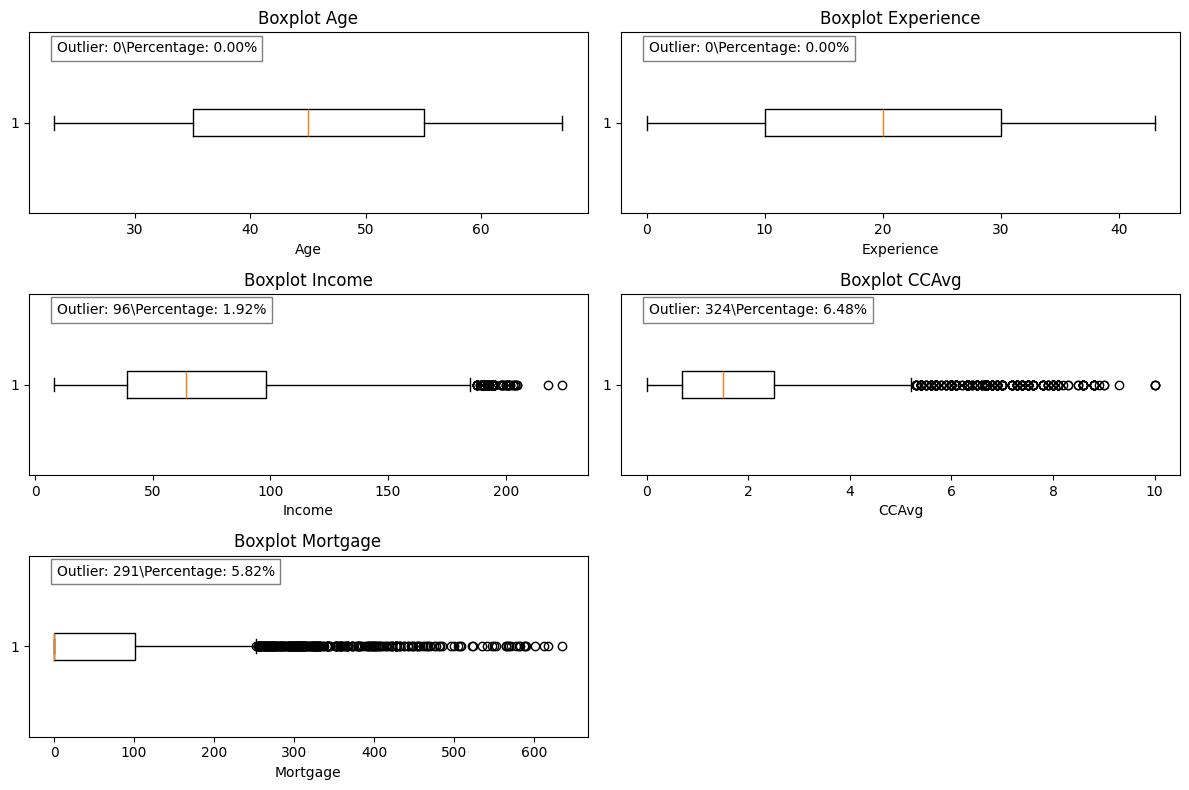

In [23]:
def check_outliers(df, columns):
    fig, axes = plt.subplots(3, 2, figsize=(12, 8))
    axes = axes.flatten()  
    for i, col in enumerate(columns):
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        
        num_outliers = ((df[col] < lower_bound) | (df[col] > upper_bound)).sum()
        percentage_outliers = num_outliers / len(df) * 100
        
        axes[i].boxplot(df[col], vert=False)
        axes[i].set_title(f"Boxplot {col}")
        axes[i].set_xlabel(col)
        
        axes[i].text(0.05, 0.95, f"Outlier: {num_outliers}\Percentage: {percentage_outliers:.2f}%",
                     verticalalignment='top', horizontalalignment='left',
                     transform=axes[i].transAxes, bbox=dict(facecolor='white', alpha=0.5))
        
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])
        
    plt.tight_layout()
    plt.show()

check_outliers(df, numerical_columns)

Ternyata, hipotesis saya terbukti benar bahwa kolom **Income**, **CCAvg**, dan **Mortage** memiliki **outliers**. 
- Income: 96 buah dengan persentase sekitar 1.92% 
- CCAvg: 324 buah dengan persentase sekitar 6.48% 
- Income: 291 buah dengan persentase sekitar 5.82% 

Penjelasan tentang bagaimana saya menghandle outlier akan dijelaskan pada bagian C.) dibawah

### Heatmap Analysis

<Axes: >

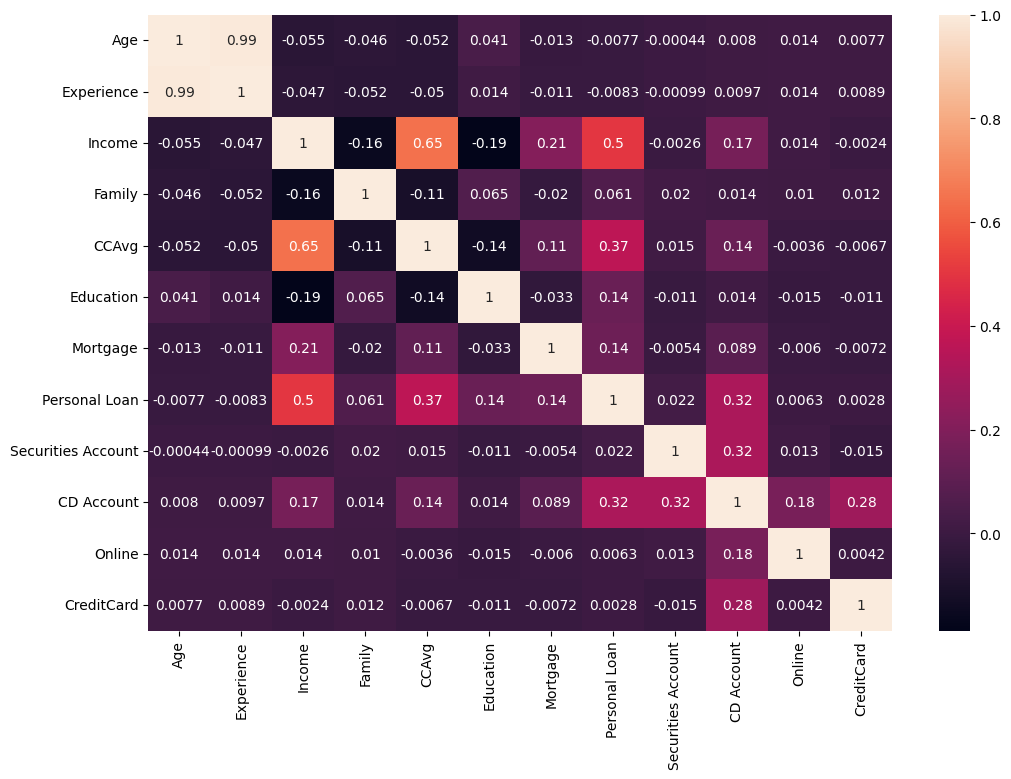

In [24]:
plt.figure(figsize = [12, 8])
sns.heatmap(df.corr(), annot = True)

Berdasarkan hasil analisis korelasi diatas, saya menarik beberapa poin penting (insight baru) untuk menambah pengetahuan mengenai dataset ini, yaitu:
1. **Experience dan Age** (0.99):
   - Korelasi yang sangat tinggi (hampir sempurna) antara pengalaman (Experience) dan usia (Age) menunjukkan bahwa keduanya sangat berkaitan secara linear.
   - Hal ini masuk akal karena umumnya pengalaman seseorang bekerja akan meningkat seiring dengan bertambahnya usia.
   - Namun, nilai korelasi yang sangat tinggi ini juga menunjukkan adanya multicollinearity, yang dapat menyebabkan masalah dalam analisis yang memerlukan independensi antar variabel.

2. **CCAvg dan Income (0.65)**:
   - Korelasi positif yang cukup kuat antara rata-rata pengeluaran kartu kredit setiap bulan (CCAvg) dan pendapatan (Income) menunjukkan bahwa ada hubungan positif antara kedua variabel tersebut.
   - Ini bisa berarti bahwa semakin tinggi pendapatan seseorang, semakin tinggi juga rata-rata pengeluaran mereka pada kartu kredit.

3. **Personal Loan dan Income** (0.5):
   - Korelasi yang positif antara peminjaman pribadi (Personal Loan) dan pendapatan (Income) menunjukkan bahwa ada hubungan positif antara kedua variabel tersebut.
   - Hal ini masuk akal karena umumnya orang dengan pendapatan yang lebih tinggi cenderung lebih berkesempatan untuk disetujui peminjaman pribadi.
   - Namun, nilai korelasi ini tidak terlalu tinggi, sehingga penting untuk memperhatikan faktor-faktor lain yang mungkin memengaruhi keputusan untuk memberikan pinjaman pribadi, seperti riwayat kredit atau tujuan penggunaan pinjaman.

4. **Personal Loan dan CCAvg** (0.37):
   - Korelasi yang positif antara peminjaman pribadi (Personal Loan) dan rata-rata pengeluaran kartu kredit (CCAvg) menunjukkan adanya hubungan positif antara kedua variabel tersebut, meskipun tidak terlalu kuat.
   - Ini bisa berarti bahwa orang yang memiliki rata-rata pengeluaran kartu kredit yang tinggi cenderung lebih mungkin disetujui untuk peminjaman pribadi.
   - Namun, nilai korelasi yang tidak terlalu tinggi menunjukkan bahwa ada faktor-faktor lain yang juga memengaruhi keputusan untuk memberikan pinjaman pribadi, dan perlu dilakukan analisis lebih lanjut untuk memahaminya jika diperlukan.

### Data Distribution

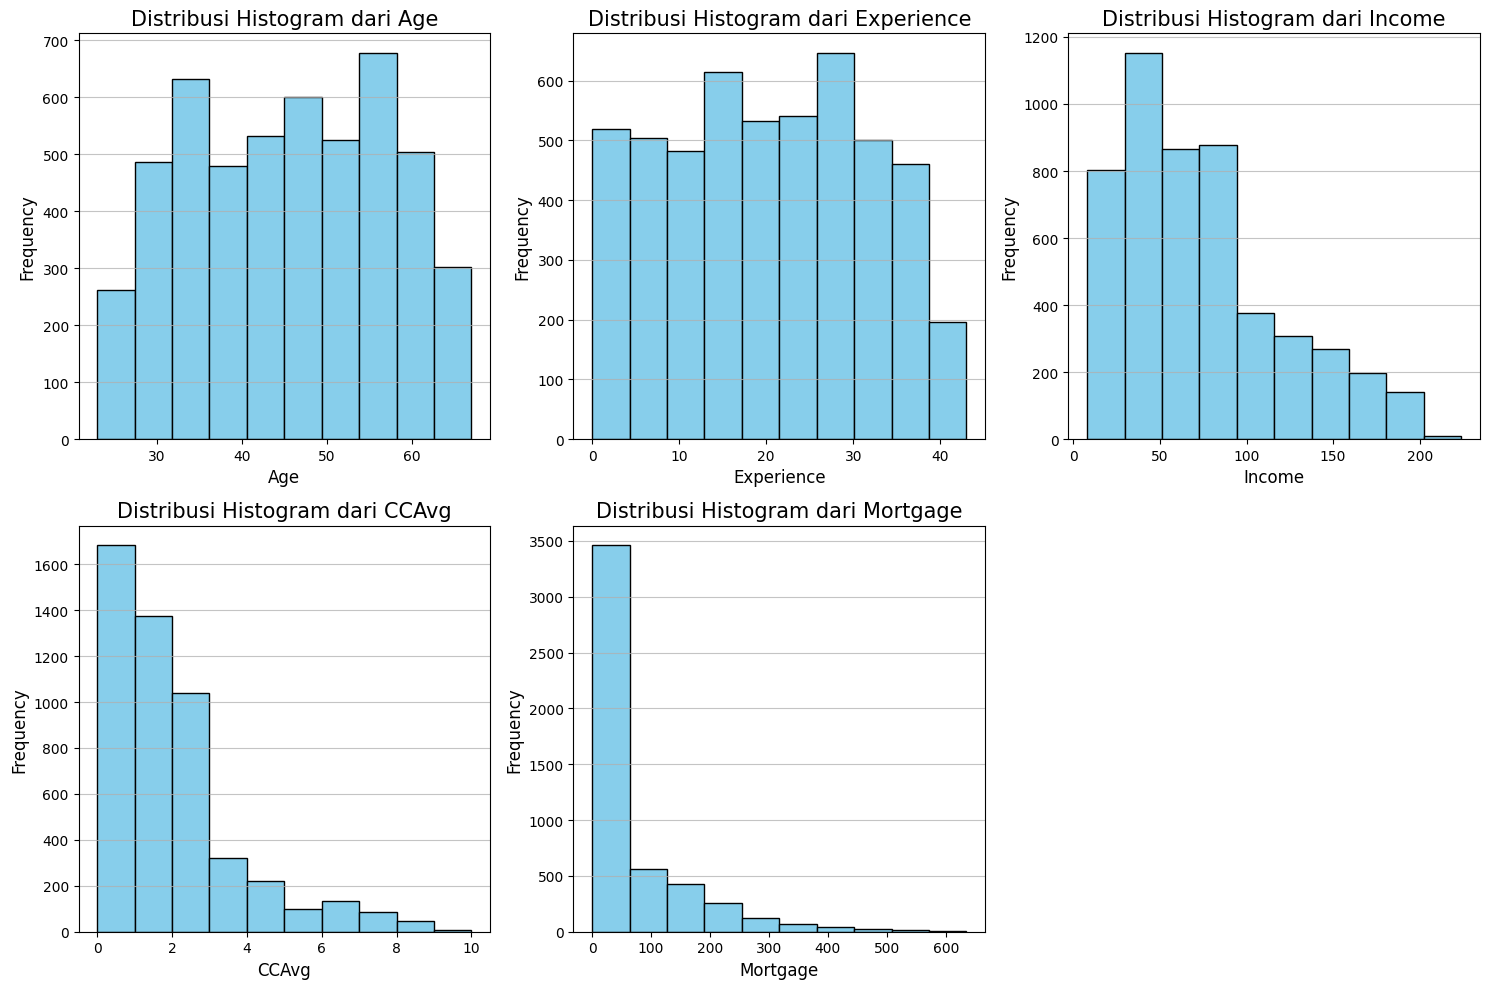

In [25]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(numerical_columns):
    axes[i].hist(df[column], bins=10, color='skyblue', edgecolor='black')
    axes[i].set_title(f'Distribusi Histogram dari {column}', fontsize=15)
    axes[i].set_xlabel(column, fontsize=12)
    axes[i].set_ylabel('Frequency', fontsize=12)
    axes[i].grid(axis='y', alpha=0.75)

for j in range(len(numerical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Histogram untuk **Age dan Experience** menunjukkan distribusi yang mendekati **normal** karena kedua fitur tersebut cenderung terdistribusi secara merata di sepanjang rentang nilainya. Ini disebabkan oleh fakta bahwa umur dan pengalaman biasanya terdistribusi secara normal di dalam populasi, dengan sebagian besar individu berada di sekitar nilai median.

Histogram untuk **Income, CCAvg, dan Mortgage** menunjukkan kecenderungan pada **right-tailed** karena sebagian besar individu cenderung memiliki nilai yang rendah untuk fitur-fitur ini, sementara ada beberapa individu yang memiliki nilai yang sangat tinggi. Hal ini sesuai dengan distribusi kekayaan di masyarakat, di mana sebagian besar orang memiliki pendapatan dan pengeluaran yang rendah, sedangkan hanya sedikit orang yang memiliki pendapatan atau pengeluaran yang sangat tinggi.

Dari histogram tersebut, saya dapat mengambil beberapa benang merah, sebagai berikut:
1. **Sebagian besar pelanggan memiliki kondisi keuangan yang relatif stabil**:
   - Mayoritas pelanggan memiliki pendapatan, pengeluaran bulanan kartu kredit (CCAvg), dan nilai hipotek (Mortgage) yang rendah.
   - Hal ini menunjukkan bahwa sebagian besar pelanggan berada dalam kategori pendapatan menengah ke bawah dan memiliki komitmen keuangan yang terjangkau.

2. **Ada segmen kecil pelanggan dengan kondisi keuangan yang tinggi**:
   - Meskipun mayoritas pelanggan memiliki kondisi keuangan yang stabil, terdapat sejumlah kecil pelanggan dengan pendapatan, pengeluaran bulanan kartu kredit, dan nilai hipotek yang tinggi.
   - Hal ini menunjukkan adanya variasi besar dalam kondisi keuangan di antara pelanggan, dengan beberapa individu memiliki pendapatan dan komitmen keuangan yang jauh di atas rata-rata.

3. **Variasi dalam kondisi keuangan dapat mempengaruhi keputusan bank dalam memberikan pinjaman pribadi**:
   - Informasi tentang pendapatan, pengeluaran bulanan kartu kredit, dan nilai hipotek dapat menjadi faktor penting dalam pengambilan keputusan untuk memberikan pinjaman pribadi.
   - Pelanggan dengan pendapatan tinggi, pengeluaran bulanan kartu kredit yang tinggi, dan nilai hipotek yang rendah mungkin memiliki kemungkinan lebih tinggi untuk mendapatkan pinjaman pribadi, dan sebaliknya.

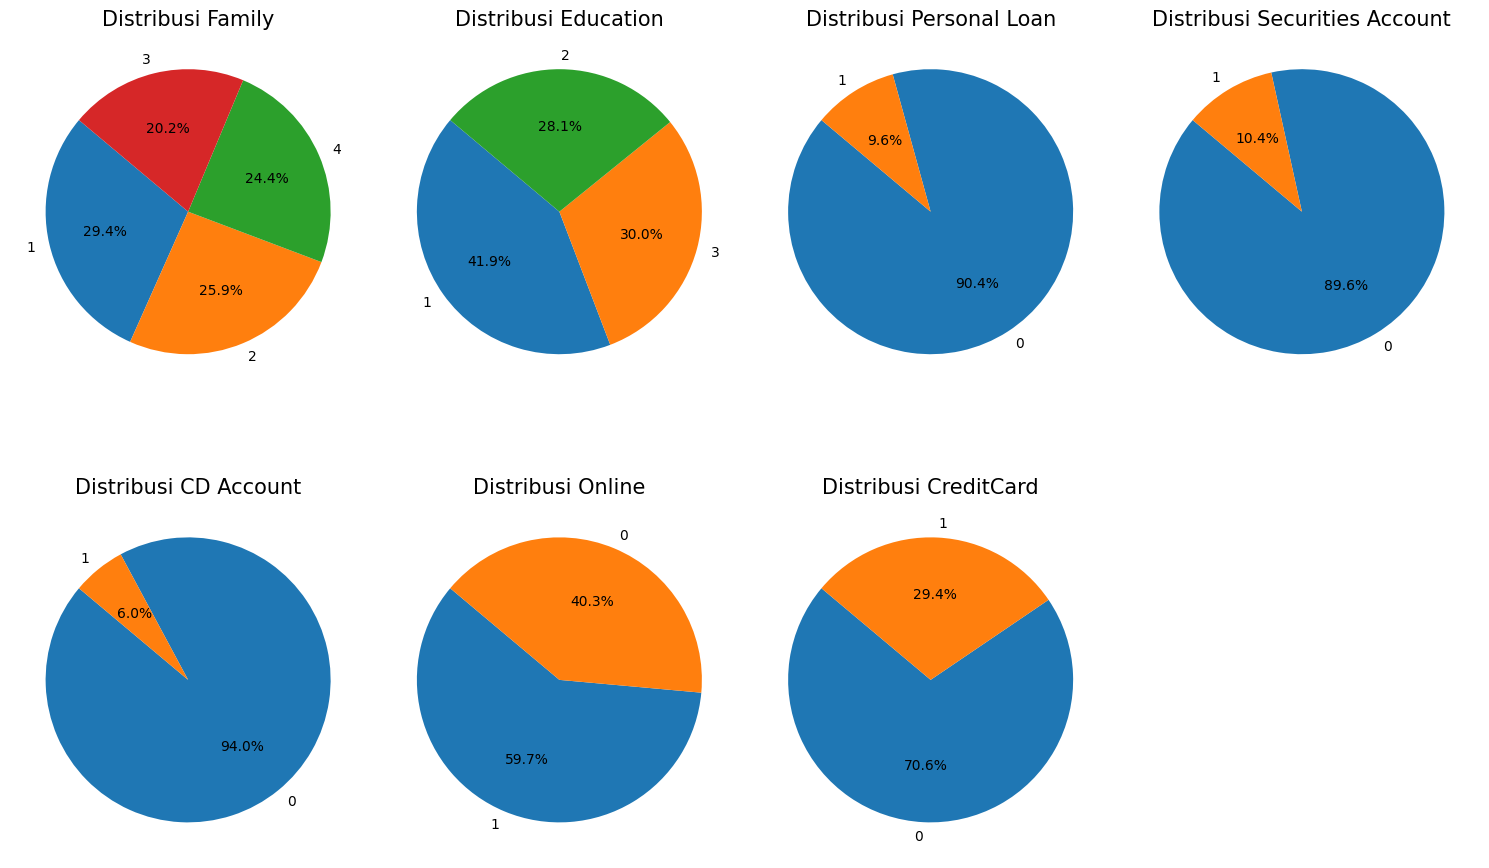

In [26]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 10))
axes = axes.flatten()

for i, column in enumerate(categorical_columns):
    value_counts = df[column].value_counts()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=140)
    axes[i].set_title(f'Distribusi {column}', fontsize=15)

for j in range(len(categorical_columns), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

1. **Family**:
   - Persebaran data yang kurang lebih sama untuk jumlah keluarga yang berbeda menunjukkan bahwa pelanggan dalam dataset ini memiliki ragam dalam struktur keluarga.
   - Struktur keluarga pelanggan bisa menjadi faktor penting dalam menentukan kebutuhan keuangan dan tanggung jawab finansial mereka. Misalnya, keluarga dengan jumlah anggota yang lebih besar mungkin memiliki kebutuhan keuangan yang lebih besar dan lebih memerlukan pinjaman pribadi.

2. **Education**:
   - Persentase yang cukup merata di antara tingkat pendidikan menunjukkan bahwa pelanggan dataset ini memiliki tingkat pendidikan yang beragam.
   - Tingkat pendidikan dapat memengaruhi keputusan keuangan seseorang dan tingkat kesadaran mereka terhadap manajemen keuangan. Pelanggan dengan tingkat pendidikan yang lebih tinggi mungkin memiliki pemahaman yang lebih baik tentang risiko dan manfaat dari pinjaman pribadi.

3. **Personal Loan**:
   - Mayoritas pelanggan (90.4%) tidak diberikan pinjaman pribadi, sementara hanya sebagian kecil (9.6%) yang diberikan pinjaman pribadi.
   - Ini menunjukkan bahwa pemberian pinjaman pribadi mungkin merupakan keputusan yang cermat dari pihak bank, dengan pertimbangan terhadap risiko kredit dan kepatuhan terhadap kebijakan underwriting yang ketat.

4. **Securities Account, CD Account, Online, CreditCard**:
   - Persentase yang relatif rendah dari pelanggan yang memiliki rekening sekuritas, rekening CD, dan kartu kredit bank menunjukkan bahwa tidak semua pelanggan menggunakan layanan keuangan tambahan yang ditawarkan oleh bank.
   - Hal ini mungkin mengindikasikan bahwa bank dapat meningkatkan upaya pemasaran atau pendidikan kepada pelanggan tentang manfaat dari layanan tambahan tersebut. Selain itu, informasi ini juga dapat menjadi pertimbangan dalam menilai profil risiko dan kemampuan pelanggan untuk membayar kembali pinjaman pribadi.

Terkhusus kolom personal loan, securities account, dan CD account menunjukkan adanya **data imbalance**. Untuk penjelasan lebih lanjut mengenai hal ini akan dijelaskan di bagian C (dibawah)

### Train Test Validation Split

In [27]:
x = df.drop('Personal Loan', axis = 1)
y = df['Personal Loan']

In [28]:
x_train, x_remain, y_train, y_remain = train_test_split(x, y, test_size=0.2, random_state=42)
x_valid, x_test, y_valid, y_test = train_test_split(x_remain, y_remain, test_size=0.5, random_state=42)

In [29]:
print("Shape of X Train : ", x_train.shape)
print("Shape of X Test  : ", x_test.shape)
print("Shape of X Valid : ", x_valid.shape)
print("")
print("Shape of Y Train : ", y_train.shape)
print("Shape of Y Test  : ", y_test.shape)
print("Shape of Y Valid : ", y_valid.shape)

Shape of X Train :  (4000, 11)
Shape of X Test  :  (500, 11)
Shape of X Valid :  (500, 11)

Shape of Y Train :  (4000,)
Shape of Y Test  :  (500,)
Shape of Y Valid :  (500,)


Pembagian dataset untuk data train : test : val = 80 : 10 : 10 --> sudah benar

# C.) Challenges and Difficulties

Pada bagian ini, saya akan mengidentifikasikan tantangan dan kesulitan dari data tabular yang telah diberikan. Hal ini terkait dengan Kualitas Data (Data Kotor dan Hilang, Outliers), Jenis Data (Heterogenitas Fitur, Encoding Fitur Kategorikal, Skala dan Normalisasi) dan Ketidakseimbangan Kelas (Class Imbalance), beserta dengan penjelasan mengenai cara penanganannya.

### C.1) Data Quality (Dirty and Missing Data, Outliers),

1. **Tidak Ada Masalah Missing Value dan Duplicate Data**:
   - Setelah melakukan pemeriksaan terhadap dataset, saya menyimpulkan bahwa tidak ada masalah dengan nilai yang hilang (missing value) atau data duplikat.
   - Hal ini menunjukkan bahwa dataset telah diproses dengan baik dan siap untuk dilanjutkan ke tahap analisis lebih lanjut.

2. **Dirty data berupa Tipe Data yang salah pada Kolom `CCAvg` dan Value Data yang tidak valid pada kolom `Experience`**:
   - Saat memeriksa tipe data dalam kolom CCAvg, saya menemukan bahwa tipe datanya adalah objek (object) yang seharusnya seharusnya menjadi tipe data integer (float64) sehingga menyebabkan data menjadi tidak konsisten. Setelah penyelidikan lebih lanjut, saya menemukan bahwa kesalahan dalam penempatan tanda baca '/', seharusnya adalah '.' yang mengakibatkan data menjadi tidak valid. Untuk memperbaiki masalah ini, saya mengganti tipe data kolom CCAvg menjadi float.
   - Terdapat juga masalah pada nilai minimum yang **negatif**, yang tidak mungkin dalam konteks pengalaman kerja pada kolom Experience. Ini menunjukkan adanya kesalahan data yang perlu diatasi. Metode yang saya gunakan untuk mengatasi masalah tersebut adalah dengan replace nilai negatif dengan nilai absolute dari nilai negatif tersebut, dengan asumsi bahwa terjadi kesalahan ketik (typo) saat penginputan data.

3. **Adanya Outlier pada Kolom `Income`, `CCAvg`, dan `Mortgage`**:
   - Setelah melakukan analisis terhadap dataset, saya menemukan adanya outlier dalam kolom Income, CCAvg, dan Mortgage.
   - Meskipun terdapat outlier, persentase dari outlier tersebut masih tergolong kecil, yaitu kurang dari 10% dari total data.
   - Saya memutuskan untuk membiarkan outlier tersebut apa adanya, tanpa melakukan penghapusan atau penyesuaian, dengan tujuan agar model yang akan dikembangkan dapat belajar dari pola-pola yang kompleks dalam data, termasuk dari data outlier.
   - Dengan membiarkan outlier tetap ada, saya yakin bahwa model yang dikembangkan akan lebih siap untuk menghadapi situasi di dunia nyata, di mana outlier seringkali juga terjadi dan perlu dipertimbangkan dalam pengambilan keputusan.

4. **Adanya kolom `ID` dan `ZIP Code` yang tidak Relevan**:
   - Setelah melakukan crosscheck data tabular dengan deskripsi dataset yang diberikan, saya melakukan analisis lebih lanjut pada kedua kolom tersebut (sudah dijelaskan detailnya diatas) dan berkesimpulan bahwa kedua kolom tersebut tidak relevan pada proses pembuatan model nanti,
   - Saya memutuskan untuk drop kedua kolom tersebut agar dataset menjadi lebih bershih dan hanya berisi informasi relevan yang diperlukan untuk model.

### C.2) Data Types (Feature Heterogeneity, Categorical Feature Encoding, Scaling and Normalization)

1. **Feature Heterogeneity**
    - Fitur dalam dataset dapat memiliki tipe data yang berbeda. Misalnya, beberapa feature berupa numerik, sementara yang lain berupa kategorikal, atau bahkan kombinasi dari keduanya (Education). Feature seperti 'Age', 'Experience', 'Income', 'Family', dan 'Mortgage' merupakan contoh fitur numerik, sementara, 'Securities Account', 'CD Account', 'Online', 'CreditCard', dan 'Personal Loan' adalah contoh fitur kategorikal.
    - Fitur-fitur mungkin memiliki sifat statistik yang berbeda, seperti mean, median, atau standard deviation yang berbeda. Ini dapat memengaruhi analisis statistik dan model. Misalnya, distribusi data yang tidak normal pada fitur-fitur seperti 'Income', 'CCAvg', dan 'Mortgage' dapat memengaruhi kinerja model.
2. **Categorical Feature Encoding**:
   - Kolom 'Education' merupakan fitur kategorikal dengan tiga level pendidikan yang berbeda. Sementara itu, kolom-kolom seperti 'Securities Account', 'CD Account', 'Online', 'CreditCard', dan 'Personal Loan' merupakan fitur kategorikal biner.
   - Untuk fitur kategorikal dapat menggunakan teknik seperti One-Hot Encoding atau Label Encoding. Namun, dalam konteks dataset ini, feature tersebut sudah dalam bentuk binary sehingga proses encoding tidak diperlukan karena mereka sudah berbentuk integer (0 atau 1).

3. **Scaling and Normalization**:
   - Seperti yang telah disebutkan sebelumnya, terdapat perbedaan skala yang signifikan antara fitur-fitur numerikal seperti 'Income', 'CCAvg', dan 'Mortgage'.
   - Perlu melakukan scaling atau normalisasi pada fitur-fitur numerikal agar memiliki skala yang seragam. Teknik seperti Robust Scaling yang lebih tahan terhadap outlier (mengingat ada beberapa kolom numerik yang memiliki outlier) dapat digunakan untuk memastikan semua fitur memiliki rentang nilai yang serupa dan tidak mendominasi satu sama lain dalam proses learning oleh model.

Berikut proses scaling yang dilakukan pada kolom numerikal diatas:

In [30]:
columns_to_scale = ['Age', 'Experience', 'Income', 'CCAvg', 'Mortgage']
scaler = RobustScaler()

# Fit transform pada data train
x_train_scaled = x_train.copy()
x_train_scaled[columns_to_scale] = scaler.fit_transform(x_train_scaled[columns_to_scale])

# Transform pada data validasi
x_valid_scaled = x_valid.copy()
x_valid_scaled[columns_to_scale] = scaler.transform(x_valid_scaled[columns_to_scale])

# Transform pada data test
x_test_scaled = x_test.copy()
x_test_scaled[columns_to_scale] = scaler.transform(x_test_scaled[columns_to_scale])

**Beberapa penjelasan mengenai metode scaling yang saya lakukan diatas:**
1. Alasan saya hanya melakukan scaling pada kolom 'Age', 'Experience', 'Income', 'CCAvg', 'Mortgage' adalah karena fitur-fitur tersebut memiliki skala nilai yang berbeda-beda dan rentang nilai yang cukup besar, sehingga memerlukan normalisasi untuk menjaga konsistensi dan proporsi antar-fitur. 
    - Namun, untuk kolom 'Family' dan 'Education', saya memilih untuk tidak melakukan scaling karena keduanya memiliki interpretasi yang berkaitan dengan level atau jumlah yang seharusnya dipertahankan. 
    - Misalnya, semakin tinggi level pendidikan seseorang, semakin besar pengaruhnya terhadap keputusan pemberian personal loan. Begitu pula dengan jumlah anggota keluarga, di mana semakin banyak anggota keluarga, semakin besar kemungkinan adanya pengeluaran tambahan. 
    - Oleh karena itu, membiarkan fitur-fitur ini dalam skala aslinya memungkinkan untuk mempertahankan interpretasi semantik yang tepat.

2. Pemilihan Robust Scaling sebagai metode normalisasi dilakukan untuk mengatasi potensi adanya outlier dalam data. Robust Scaling menggunakan median dan interquartile range (IQR) sebagai dasar skala, sehingga lebih tahan terhadap pengaruh outlier daripada metode scaling standar seperti Min-Max Scaling atau Z-score Scaling. Dengan demikian, dapat dijaga kestabilan dalam perbandingan antar-fitur meskipun terdapat nilai yang ekstrem dalam data.

3. Pentingnya menggunakan data train untuk fitting scaler adalah untuk memastikan bahwa proses fitting hanya dilakukan berdasarkan informasi dari data yang digunakan untuk training model. Hal ini penting karena scaler harus mempelajari parameter seperti median dan IQR dari data train untuk kemudian diterapkan pada data validasi dan test. Dengan menggunakan data train untuk fitting scaler, dapat mencegah adanya kebocoran informasi dari data validasi dan test ke dalam proses training, sehingga menghasilkan evaluasi model yang lebih objektif dan konsisten.

In [31]:
x_train_scaled.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
4227,-0.65,-0.65,0.796610,1,1.210526,1,0.0,1,0,0,0
4676,-0.30,-0.35,0.067797,3,0.315789,1,0.0,1,0,1,0
800,-0.70,-0.65,1.847458,1,2.368421,1,0.0,0,0,1,0
3671,0.25,0.25,-0.779661,1,-0.578947,3,0.0,0,0,1,0
4193,0.85,0.85,-0.559322,3,-0.684211,1,0.0,0,0,1,0


In [32]:
x_valid_scaled.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
2922,0.35,0.30,-0.254237,1,-0.052632,3,0.000000,0,0,1,0
3496,-0.40,-0.35,-0.254237,4,0.263158,3,1.900990,0,0,0,0
2753,0.45,0.35,2.220339,2,1.710526,2,4.722772,0,0,0,0
1503,-0.55,-0.60,-0.203390,4,0.368421,2,0.000000,0,0,0,0
175,0.00,0.00,0.355932,4,-0.210526,2,0.000000,1,0,1,0


In [33]:
x_test_scaled.head()

,Age,Experience,Income,Family,CCAvg,Education,Mortgage,Securities Account,CD Account,Online,CreditCard
3707,-0.10,-0.10,-0.491525,1,-0.473684,3,0.000000,0,0,0,0
828,-0.50,-0.55,-0.610169,4,-0.263158,1,0.742574,0,0,1,0
2664,0.45,0.45,1.525424,1,0.473684,2,3.485149,0,0,1,0
1047,0.50,0.55,0.152542,4,0.052632,2,0.000000,0,0,0,0
3197,-0.55,-0.50,-0.593220,1,0.000000,2,0.000000,0,0,1,0


### C.3) Class Imbalance

Berdasarkan hasil EDA yang telah dilakukan sebelumnya, ditemukan bahwa kolom Personal Loan, Securities Account, dan CD Account memiliki data imbalance. Pengambilan keputusan terkait dengan penanganan data imbalance dalam konteks pembangunan model prediktif sangat penting. 

Berikut saya jabarkan hasil analisa saya terhadap class imbalance dan pendekatan yang  akan saya lakukan:
1. **Data Imbalance**
   - Data imbalance merujuk pada situasi di mana kelas-kelas dalam dataset memiliki distribusi yang tidak seimbang. Dalam konteks ini, kolom Personal Loan, Securities Account, dan CD Account menunjukkan ketidakseimbangan yang signifikan antara kelas yang positif (misalnya, pelanggan yang mendapatkan pinjaman pribadi atau memiliki akun sekuritas) dan kelas yang negatif (misalnya, pelanggan yang tidak mendapatkan pinjaman pribadi atau tidak memiliki akun sekuritas).
   - Pada kasus ini, terdapat prevalensi yang jauh lebih tinggi dari kelas yang negatif dibandingkan dengan kelas yang positif. Misalnya, dalam kolom Personal Loan, hanya sebagian kecil dari pelanggan yang diberikan pinjaman pribadi (kelas positif), sementara mayoritas pelanggan tidak diberikan pinjaman pribadi (kelas negatif).

2. **Penggunaan Neural Network**
   - Neural network adalah salah satu algoritma pembelajaran mesin yang sangat fleksibel dan mampu menangani masalah-masalah kompleks, termasuk masalah klasifikasi biner seperti prediksi personal loan.
   - Neural network dapat menangani data yang tidak seimbang dengan baik, terutama jika dilatih dengan benar dan disesuaikan dengan parameter yang sesuai.
   - Dengan menggunakan pendekatan neural network, model memiliki kemampuan untuk belajar pola-pola yang kompleks dalam data, bahkan dalam situasi ketidakseimbangan yang signifikan.

3. **Alasan Mempertahankan Data Imbalance**
   - Memilih untuk mempertahankan data imbalance bertujuan untuk membuat model dapat belajar dari distribusi yang sesungguhnya dari data yang ada di dunia nyata.
   - Pada kebanyakan kasus di dunia nyata, data tidak selalu seimbang, dan pengambilan keputusan yang berdasarkan pada data yang tidak seimbang dapat memberikan gambaran yang lebih akurat tentang situasi yang sebenarnya.
   - Dengan menggunakan data yang tidak seimbang, model memiliki kesempatan untuk mengenali dan mempelajari pola-pola yang mungkin tersembunyi di dalam kelas minoritas, yang mungkin penting dalam mengambil keputusan di dunia nyata.

Dengan mempertahankan data yang tidak seimbang dan menggunakan pendekatan neural network, tujuan utamanya adalah untuk menghasilkan model yang dapat memprediksi personal loan dengan tingkat akurasi yang tinggi, bahkan dalam kondisi ketidakseimbangan yang signifikan, sehingga model tersebut dapat diandalkan untuk digunakan dalam kasus-kasus nyata di dunia nyata.

## D.) Baseline Architecture

Pada bagian ini, saya membuat arsitektur baseline dengan 11 nodes input layer, 2 buah hidden layer dengan banyak 2 × 11 nodes awal dan layer akhir sesuai dengan banyak kelas nya yaitu 2.
(11, 2 × 11, 2 × 11, 2). 
Activation function yang saya gunakan untuk tiap hidden layer adalah menggunakan ReLU

In [37]:
model = Sequential([
    Dense(11, input_shape=(11,)),
    Dense(22, activation='relu'),
    Dense(22, activation='relu'),
    Dense(2, activation='sigmoid')
])
model.compile(optimizer='sgd', loss='binary_crossentropy', metrics=['accuracy'])

In [38]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_4 (Dense)             (None, 11)                132       
                                                                 
 dense_5 (Dense)             (None, 22)                264       
                                                                 
 dense_6 (Dense)             (None, 22)                506       
                                                                 
 dense_7 (Dense)             (None, 2)                 46        
                                                                 
Total params: 948
Trainable params: 948
Non-trainable params: 0
_________________________________________________________________


In [39]:
y_train_categorical = to_categorical(y_train)
y_valid_categorical = to_categorical(y_valid)

fitted_model = model.fit(x_train_scaled, y_train_categorical, epochs=50, validation_data=(x_valid_scaled, y_valid_categorical), verbose=1)

Epoch 1/50


125/125 [==============================] - 2s 4ms/step - loss: 0.4768 - accuracy: 0.8923 - val_loss: 0.3745 - val_accuracy: 0.8840
Epoch 2/50
125/125 [==============================] - 0s 2ms/step - loss: 0.3266 - accuracy: 0.9062 - val_loss: 0.3419 - val_accuracy: 0.8840
Epoch 3/50
125/125 [==============================] - 0s 2ms/step - loss: 0.3050 - accuracy: 0.9062 - val_loss: 0.3220 - val_accuracy: 0.8840
Epoch 4/50
125/125 [==============================] - 0s 2ms/step - loss: 0.2920 - accuracy: 0.9062 - val_loss: 0.3038 - val_accuracy: 0.8840
Epoch 5/50
125/125 [==============================] - 0s 2ms/step - loss: 0.2809 - accuracy: 0.9062 - val_loss: 0.2888 - val_accuracy: 0.8840
Epoch 6/50
125/125 [==============================] - 0s 2ms/step - loss: 0.2707 - accuracy: 0.9062 - val_loss: 0.2732 - val_accuracy: 0.8840
Epoch 7/50
125/125 [==============================] - 0s 2ms/step - loss: 0.2609 - accuracy: 0.9062 - val_loss: 0.2591 - val_accuracy: 0.8840
Epoch 8/50
125/12

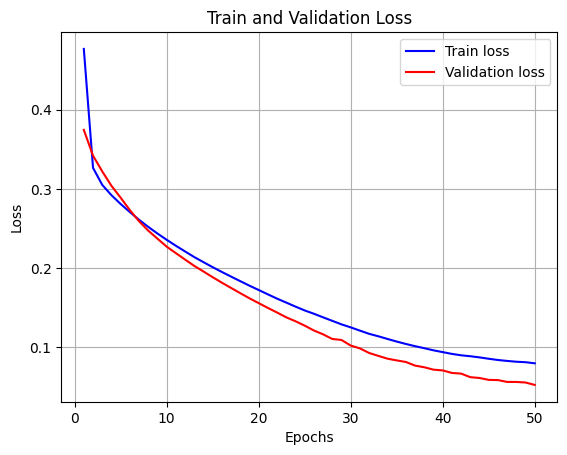

In [41]:
# Mendapatkan history dari fitting model
train_loss = fitted_model.history['loss']
val_loss = fitted_model.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Visualisasi train loss dan validation loss
plt.plot(epochs, train_loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.show()

Dari hasil pelatihan model di atas, terdapat beberapa insight yang dapat diambil:
1. **Performa Awal**: Pada awal pelatihan (Epoch 1), baik train loss maupun validation loss memiliki nilai yang tinggi, sementara akurasi pada data validasi (val_accuracy) relatif rendah (0.8840). Hal ini menunjukkan bahwa model awal masih belum mampu mempelajari pola-pola yang kompleks dari data dengan baik.

2. **Penurunan Loss**: Selama pelatihan, baik train loss maupun validation loss mengalami penurunan secara konsisten dari epoch ke epoch. Ini menandakan bahwa model secara bertahap memperbaiki kemampuannya untuk memprediksi dengan lebih baik, dan mungkin mampu menangkap pola-pola yang lebih subtan dari data.

3. **Peningkatan Akurasi**: Bersamaan dengan penurunan loss, akurasi pada data validasi (val_accuracy) juga meningkat seiring dengan jumlah epoch. Hal ini menunjukkan bahwa model semakin baik dalam memprediksi kelas-kelas pada data yang belum pernah dilihat sebelumnya.

4. **Convergence**: Grafik loss dari kedua train dan validation set cenderung konvergen, yang menunjukkan bahwa model sudah tidak lagi mengalami penurunan loss yang signifikan. Ini menandakan bahwa model telah mencapai titik di mana peningkatan lebih lanjut dalam pelatihan mungkin tidak lagi memberikan peningkatan yang signifikan dalam kinerja.

5. **Overfitting Prevention**: Tidak ada tanda-tanda yang jelas dari overfitting, karena kedua kurva train loss dan validation loss tetap relatif dekat sepanjang proses pelatihan. Ini menunjukkan bahwa penambahan jumlah epoch dan penerapan early stopping telah berhasil mencegah model dari overfitting pada data training.

In [42]:
y_pred = model.predict(x_test_scaled).argmax(axis=1)
print(classification_report(y_test, y_pred))

16/16 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       453
           1       0.97      0.81      0.88        47

    accuracy                           0.98       500
   macro avg       0.98      0.90      0.94       500
weighted avg       0.98      0.98      0.98       500



## E.) Architectural Modifications

**Accuracy** tidak selalu relevan dalam konteks masalah klasifikasi yang memiliki class imbalance, seperti pada kasus Personal Loan. Hal ini dikarenakan accuracy hanya mengukur seberapa sering model secara keseluruhan memprediksi dengan benar, tanpa memperhatikan seberapa baik model tersebut dalam mengklasifikasikan kelas minoritas (dalam hal ini, pelanggan yang sebenarnya layak mendapatkan pinjaman).

Dalam kasus class imbalance, di mana jumlah sampel dalam kelas positif (misalnya, pelanggan yang sebenarnya layak mendapatkan pinjaman) jauh lebih sedikit daripada jumlah sampel dalam kelas negatif (misalnya, pelanggan yang tidak layak mendapatkan pinjaman), model dapat mencapai tingkat akurasi yang tinggi hanya dengan "mengklasifikasikan" mayoritas sampel ke kelas mayoritas. Sebagai contoh, jika hanya 5% dari pelanggan yang layak mendapatkan pinjaman, model yang memprediksi semua pelanggan sebagai tidak layak mendapatkan pinjaman akan memiliki akurasi sekitar 95%, tetapi tidak akan berguna dalam praktiknya.

Oleh karena itu, dalam konteks Personal Loan, di mana targetnya adalah apakah pelanggan akan diberikan pinjaman atau tidak, metrik-metrik seperti Precision, Recall, dan F1-score sangat relevan untuk mengevaluasi kinerja model dalam mengatasi masalah class imbalance. Berikut adalah penjelasan konteks penggunaan metrik-metrik tersebut:

1. **Precision**: Dalam konteks Personal Loan, Precision dapat diinterpretasikan sebagai proporsi dari pelanggan yang diprediksi akan diberikan pinjaman dan benar-benar layak untuk menerima pinjaman dari semua pelanggan yang diprediksi akan diberikan pinjaman. Dalam hal ini, meminimalkan false positives (misalnya, mengklasifikasikan pelanggan yang seharusnya tidak mendapatkan pinjaman sebagai pelanggan yang layak mendapatkan pinjaman) penting untuk meminimalkan risiko kredit yang tidak menguntungkan.

2. **Recall**: Dalam konteks Personal Loan, Recall dapat diinterpretasikan sebagai proporsi dari pelanggan yang benar-benar layak untuk menerima pinjaman dan diprediksi dengan benar sebagai pelanggan yang layak mendapatkan pinjaman dari semua pelanggan yang sebenarnya layak mendapatkan pinjaman. Dalam hal ini, meminimalkan false negatives (misalnya, mengklasifikasikan pelanggan yang seharusnya mendapatkan pinjaman sebagai pelanggan yang tidak layak mendapatkan pinjaman) penting untuk memastikan bahwa kesempatan pinjaman yang layak tidak terlewatkan.

3. **F1-score**: F1-score memberikan keseimbangan antara Precision dan Recall, yang berguna untuk mengevaluasi kinerja model secara keseluruhan dalam menangani class imbalance. Dalam kasus Personal Loan, F1-score akan membantu mengevaluasi seberapa baik model dapat mengklasifikasikan pelanggan yang layak dan tidak layak mendapatkan pinjaman secara seimbang, tanpa terlalu banyak memprioritaskan satu jenis kesalahan (false positives atau false negatives) dibandingkan yang lain.

Jadi, metrics yang apple to apple dengan accuracy dalam kasus ini adalah F1-Score

Dengan mempertimbangkan insight di atas, modifikasi arsitektur model dapat dilakukan untuk mencapai nilai F1-Score optimal dan mencegah overfitting. 
Beberapa pendekatan yang dapat dilakukan adalah:
1. Penambahan Regularisasi: Menggunakan teknik regularisasi seperti dropout atau L2 regularization untuk mencegah overfitting.
2. Penyesuaian Jumlah Layer atau Neuron: Menambah jumlah layer atau neuron dalam model untuk menyesuaikan kompleksitas model dengan kompleksitas data.
3. Optimasi Hyperparameter: Mengoptimalkan hyperparameter seperti jumlah epoch untuk meningkatkan kinerja model.
4. Pemilihan Fungsi Aktivasi: Mencoba fungsi aktivasi lain seperti Leaky ReLU untuk melihat apakah kinerja model dapat ditingkatkan.
5. Penggunaan early Stopping: Mencegah overfitting dan memastikan bahwa model yang dihasilkan memiliki kinerja yang optimal pada data yang belum pernah dilihat sebelumnya.

In [57]:
model2 = Sequential([
    Dense(11, input_shape=(11,)),
    Dense(128),
    LeakyReLU(alpha=0.1),
    Dropout(0.25),
    Dense(64),
    LeakyReLU(alpha=0.1),
    Dense(32),
    LeakyReLU(alpha=0.1),
    Dropout(0.25),
    Dense(16),
    LeakyReLU(alpha=0.1),
    Dense(2, activation='sigmoid')
])

model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [58]:
model2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 11)                132       
                                                                 
 dense_21 (Dense)            (None, 128)               1536      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 128)               0         
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_22 (Dense)            (None, 64)                8256      
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 32)               

In [63]:
callbacks = [EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]

Penggunaan early stopping sangat penting dalam training neural network karena membantu mencegah overfitting dan memastikan bahwa model yang dihasilkan memiliki kinerja yang optimal pada data yang belum pernah dilihat sebelumnya. Dengan memonitor kinerja model pada dataset validasi selama pelatihan, early stopping memungkinkan pelatihan untuk dihentikan secara otomatis saat tidak ada peningkatan dalam kinerja model, seperti peningkatan loss, setelah beberapa epoch. 

Dalam kasus di mana pelatihan dihentikan setelah 10 epoch tanpa peningkatan (patience=10), early stopping membantu memastikan bahwa model yang dihasilkan tidak terlalu "menguji" data pelatihan dan mampu lebih baik dalam mengeneralisasi pola pada data baru.

In [64]:
fitted_model2 = model2.fit(x_train_scaled, y_train_categorical, epochs=100, validation_data=(x_valid_scaled, y_valid_categorical), 
                         callbacks=callbacks, verbose=1)

Epoch 1/100


125/125 [==============================] - 0s 4ms/step - loss: 0.0342 - accuracy: 0.9870 - val_loss: 0.0199 - val_accuracy: 0.9880
Epoch 2/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0317 - accuracy: 0.9868 - val_loss: 0.0185 - val_accuracy: 0.9940
Epoch 3/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9885 - val_loss: 0.0197 - val_accuracy: 0.9940
Epoch 4/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0283 - accuracy: 0.9898 - val_loss: 0.0160 - val_accuracy: 0.9920
Epoch 5/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0294 - accuracy: 0.9858 - val_loss: 0.0149 - val_accuracy: 0.9960
Epoch 6/100
125/125 [==============================] - 0s 3ms/step - loss: 0.0265 - accuracy: 0.9877 - val_loss: 0.0220 - val_accuracy: 0.9920
Epoch 7/100
125/125 [==============================] - 0s 2ms/step - loss: 0.0289 - accuracy: 0.9893 - val_loss: 0.0151 - val_accuracy: 0.9920
Epoch 8/100

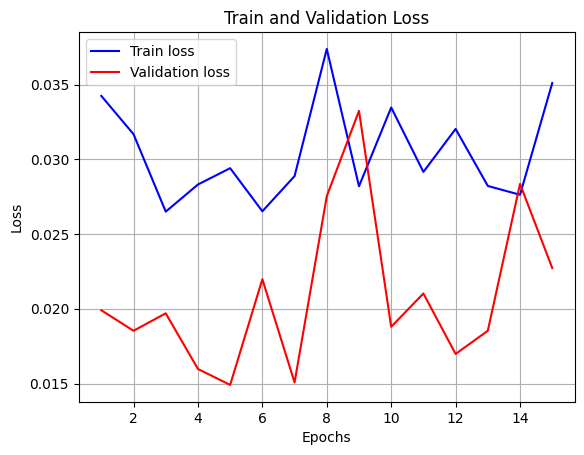

In [65]:
# Mendapatkan history dari fitting model
train_loss = fitted_model2.history['loss']
val_loss = fitted_model2.history['val_loss']
epochs = range(1, len(train_loss) + 1)

# Visualisasi train loss dan validation loss
plt.plot(epochs, train_loss, 'b', label='Train loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Train and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True) 
plt.show()

Dari hasil training yang diberikan untuk Model 2 (improvement dari model 1) dengan 100 epoch, terdapat beberapa insight yang bisa diambil:

1. **Performa Awal**: Pada awal pelatihan (Epoch 1), baik train loss maupun validation loss memiliki nilai yang rendah, dan akurasi pada data validasi (val_accuracy) tinggi (0.9880). Ini menunjukkan bahwa model awal dari pelatihan ini telah memulai dari kondisi yang baik dan mampu melakukan klasifikasi dengan baik pada data validasi.

2. **Perubahan Loss**: Selama pelatihan, baik train loss maupun validation loss mengalami fluktuasi kecil (zig-zag) karena skala loss yang semakin kecil. Meskipun terjadi fluktuasi, tren umum menunjukkan penurunan yang stabil dari epoch ke epoch. Hal ini menandakan bahwa model secara bertahap memperbaiki kemampuannya untuk memprediksi dengan lebih baik, bahkan ketika mendekati kinerja optimal.

3. **Konsistensi Validation Loss**: Meskipun terjadi fluktuasi, validation loss tetap selalu berada di bawah train loss sepanjang pelatihan. Ini menunjukkan bahwa model tidak mengalami overfitting pada data training, karena mampu melakukan generalisasi dengan baik pada data validasi yang belum pernah dilihat sebelumnya.

4. **Peningkatan Akurasi**: Akurasi pada data validasi (val_accuracy) tetap meningkat seiring dengan peningkatan jumlah epoch. Hal ini menunjukkan bahwa model semakin baik dalam memprediksi kelas-kelas pada data yang belum pernah dilihat sebelumnya.

5. **Convergence**: Grafik loss dari kedua train dan validation set cenderung konvergen, yang menunjukkan bahwa model sudah mencapai titik di mana peningkatan lebih lanjut dalam pelatihan mungkin tidak lagi memberikan peningkatan yang signifikan dalam kinerja.

Dari hasil pelatihan ini, dapat disimpulkan bahwa Model 2 telah melalui proses training yang sukses. Meskipun terjadi fluktuasi kecil dalam loss, model tetap berhasil memperbaiki kinerjanya secara keseluruhan tanpa mengalami overfitting. Oleh karena itu, Model 2 diharapkan dapat memberikan kinerja yang baik dalam mengklasifikasikan data baru, dan meningkatkan kemampuan prediksi dibandingkan dengan model sebelumnya.

In [66]:
y_pred2 = model2.predict(x_test_scaled).argmax(axis=1)
print(classification_report(y_test, y_pred2))

 1/16 [>.............................] - ETA: 0s

16/16 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       453
           1       0.98      0.85      0.91        47

    accuracy                           0.98       500
   macro avg       0.98      0.92      0.95       500
weighted avg       0.98      0.98      0.98       500



## F.) Evaluation

Pada bagian ini, saya akan melakukan evaluasi unjuk kerja kedua arsitektur di atas pada test set dengan mencari nilai accuracy, precision, recall dan F1-Score beserta dengan penjelasan mengenai hasilnya dengan rinci.

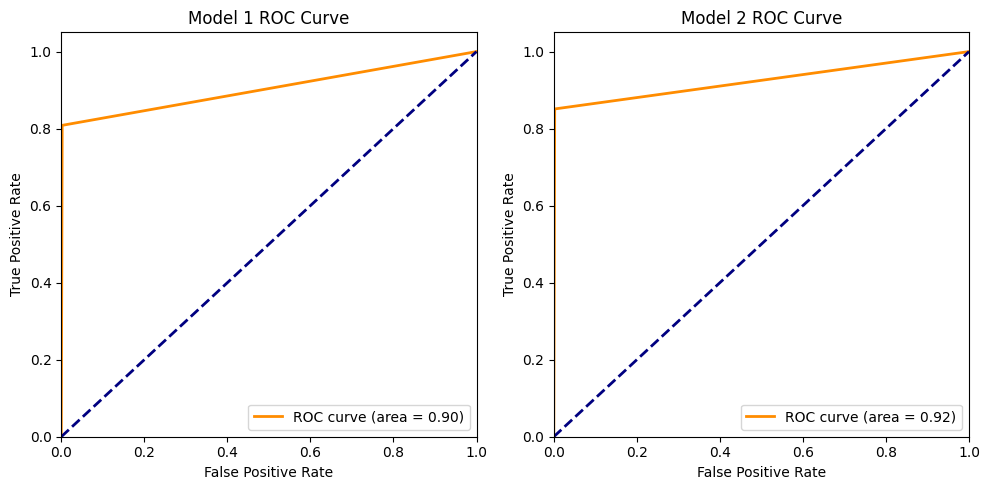

In [67]:
# Menghitung FPR dan TPR untuk model pertama
fpr1, tpr1, _ = roc_curve(y_test, y_pred)
roc_auc1 = auc(fpr1, tpr1)

# Menghitung FPR dan TPR untuk model kedua
fpr2, tpr2, _ = roc_curve(y_test, y_pred2)
roc_auc2 = auc(fpr2, tpr2)

# Visualisasi ROC untuk kedua model
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.plot(fpr1, tpr1, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc1)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 1 ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr2, tpr2, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc2)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Model 2 ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()

**Insight dari ROC Curve untuk Performa Kedua Model**
1. Akurasi Model
    - Nilai AUC (Area Under the Curve) pada ROC curve pada model pertama maupun kedua tidak beda jauh, yaitu 0,90 dan 0,92. Nilai ini menunjukkan bahwa kedua model memiliki akurasi yang cukup tinggi dalam memprediksi apakah pelanggan akan mendapatkan pinjaman personal atau tidak. Semakin tinggi nilai AUC, semakin baik akurasi model. Dalam kasus ini, nilai AUC tersebut menunjukkan bahwa kedua model mampu membedakan dengan baik antara pelanggan yang akan mendapatkan pinjaman dan yang tidak.

2. Sensitivitas dan Spesifisitas
    - ROC curve menunjukkan hubungan antara sensitivitas dan spesifisitas model. Sensitivitas adalah proporsi pelanggan yang benar-benar akan mendapatkan pinjaman yang diprediksi akan mendapatkan pinjaman. Spesifisitas adalah proporsi pelanggan yang benar-benar tidak akan mendapatkan pinjaman yang diprediksi tidak akan mendapatkan pinjaman.
    - Pada kedua ROC curve diatas, dapat dilihat bahwa kedua model memiliki sensitivitas yang tinggi pada nilai false positive rate yang rendah. Hal ini berarti bahwa kedua model mampu mengidentifikasi dengan baik pelanggan yang benar-benar akan mendapatkan pinjaman. Namun, spesifisitas pada model relatif rendah pada nilai false positive rate yang tinggi. Hal ini berarti bahwa kedua model tersebut lebih cenderung salah mengidentifikasi pelanggan yang tidak akan mendapatkan pinjaman sebagai pelanggan yang akan mendapatkan pinjaman.

3. Class Imbalance
    - ROC curve Anda menunjukkan bahwa terdapat class imbalance, di mana kelas 0 (pelanggan yang tidak akan mendapatkan pinjaman) mendominasi kelas 1 (pelanggan yang akan mendapatkan pinjaman). Hal ini dapat memengaruhi performa model Anda, terutama pada nilai false positive rate yang tinggi.

Secara keseluruhan, ROC curve diatas menunjukkan bahwa model tersebut memiliki akurasi yang cukup tinggi dalam memprediksi apakah pelanggan akan mendapatkan pinjaman personal atau tidak. Model diatas memiliki sensitivitas yang tinggi, tetapi spesifisitasnya relatif rendah.

In [68]:
# Fungsi untuk menghitung metrics
def calculate_metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_pred)
    return accuracy, precision, recall, f1, auc

# Menghitung metrics untuk model
accuracy_model, precision_model, recall_model, f1_model, auc_model = calculate_metrics(y_test, y_pred)

# Menghitung metrics untuk model2
accuracy_model2, precision_model2, recall_model2, f1_model2, auc_model2 = calculate_metrics(y_test, y_pred2)

# Menyimpan hasil metrics dalam bentuk tabel
metrics_data = {
    'Model': ['Model 1', 'Model 2'],
    'Accuracy': [accuracy_model, accuracy_model2],
    'Precision': [precision_model, precision_model2],
    'Recall': [recall_model, recall_model2],
    'F1-Score': [f1_model, f1_model2],
    'AUC Score': [auc_model, auc_model2]
}

metrics_df = pd.DataFrame(metrics_data)
print(metrics_df)


     Model  Accuracy  Precision    Recall  F1-Score  AUC Score
0  Model 1     0.980   0.974359  0.808511  0.883721   0.903152
1  Model 2     0.984   0.975610  0.851064  0.909091   0.924428


**Hasil dari evaluasi kedua model**:
- Kedua model memiliki tingkat akurasi yang tinggi, tetapi penting untuk diingat bahwa dalam kasus data yang tidak seimbang seperti Personal Loan, akurasi tidak memberikan gambaran yang lengkap tentang kinerja model. Oleh karena itu, harus melihat metrik lain seperti precision, recall, dan F1-score dan AUC score untuk mendapatkan pemahaman yang lebih baik tentang kemampuan model dalam menangani data yang tidak seimbang.

- Saat mengevaluasi kinerja model secara keseluruhan, tentunya ingin mencari keseimbangan antara precision dan recall, yang tercermin dalam F1-score. F1-score menggabungkan kedua metrik ini menjadi satu nilai, sehingga memberikan gambaran yang lebih holistik tentang kinerja model.

**Kesimpulan:**

Dalam konteks Personal Loan, di mana data cenderung tidak seimbang karena hanya sebagian kecil dari pelanggan yang akan diberikan pinjaman, F1-score menjadi metrik evaluasi yang paling relevan. F1-score mengukur keseimbangan antara presisi (kemampuan model untuk memprediksi kelas positif secara akurat) dan recall (kemampuan model untuk mengidentifikasi semua sampel yang benar-benar termasuk dalam kelas positif).

Dari kedua model yang dievaluasi, Model 2 memiliki F1-score yang lebih tinggi (90.91%) dibandingkan dengan Model 1 (88.37%). Hal ini menunjukkan bahwa Model 2 lebih baik dalam menangani ketidakseimbangan kelas pada dataset Personal Loan, dengan kemampuan yang lebih baik dalam memprediksi baik sampel positif maupun negatif secara akurat. Meskipun keduanya memiliki akurasi yang tinggi, Model 2 memberikan keseimbangan yang lebih baik antara presisi dan recall, yang merupakan indikasi yang lebih baik untuk menghadapi masalah kelas yang tidak seimbang.

Selain itu, Model 2 juga memiliki AUC score yang lebih tinggi (92.44%) dibandingkan dengan Model 1 (90.32%), menunjukkan bahwa Model 2 memiliki kemampuan yang lebih baik dalam membedakan antara kelas positif dan negatif.

Dengan demikian, dalam konteks aplikasi praktis, Model 2 lebih disarankan karena memberikan kinerja yang lebih baik dalam mengatasi masalah ketidakseimbangan kelas pada dataset Personal Loan, yang dapat menghasilkan keputusan yang lebih baik dalam memberikan pinjaman kepada pelanggan.

=================================================================================================================================================

*Tambahan penjelasan:*

Model kedua lebih baik dalam mengatasi class imbalance pada Personal Loan berdasarkan peningkatan metrik precision, recall, dan F1-score yang diamati. Berikut adalah beberapa alasan mengapa model kedua bisa lebih baik:

1. **Penambahan Dropout**: Dropout digunakan untuk mencegah overfitting dengan secara acak menghapus sebagian unit (neuron) pada setiap iterasi training. Ini membantu model untuk tidak terlalu mengandalkan fitur atau pola tertentu dalam data training, sehingga membuatnya lebih generalis.

2. **Penambahan Hidden Layer & Jumlah Neuron**: Model kedua memiliki lebih banyak layer dan jumlah neuron dibandingkan dengan model pertama. Dengan begitu, model memiliki kapasitas yang lebih besar untuk mempelajari representasi yang lebih kompleks dari data, yang dapat membantu dalam menangkap pola yang lebih rumit dan subtan dari data yang tidak seimbang.

3. **Penggunaan Leaky ReLU**: Leaky ReLU digunakan sebagai fungsi aktivasi dalam beberapa lapisan model kedua. Leaky ReLU dapat mengatasi masalah "dying ReLU" yang dapat terjadi pada ReLU biasa dengan memungkinkan gradien yang kecil tetap mengalir kembali ke lapisan sebelumnya. Ini membantu dalam mengurangi kemungkinan terjebak di titik mati, yang mungkin terjadi saat melatih model pada dataset yang tidak seimbang (class imbalance).

4. **Penggunaan Optimizer Adam**: Optimizer Adam sering kali lebih efisien dalam menyesuaikan laju pembelajaran secara adaptif untuk setiap parameter model. Ini membantu dalam menavigasi ruang parameter dengan lebih baik, terutama pada data yang tidak seimbang, di mana distribusi gradien mungkin berbeda untuk setiap kelas.

5. **Penambahan Jumlah Epoch**: Pada training model kedua, jumlah epoch ditingkatkan menjadi dua kali lipat dari model pertama, yaitu dari 50 menjadi 100. Penambahan ini memberikan lebih banyak iterasi bagi model untuk mempelajari pola-pola dalam data. Namun demikian, peningkatan jumlah epoch dapat meningkatkan risiko overfitting, terutama pada dataset yang tidak seimbang seperti Personal Loan. Untuk mengatasi masalah ini, diterapkan teknik early stopping.

6. **Early Stopping**: Early stopping adalah teknik yang digunakan untuk menghentikan proses pelatihan (training) saat performa model mulai menurun pada dataset validasi. Dalam konteks dataset yang tidak seimbang, early stopping membantu mencegah model dari overfitting pada data training dengan memonitor performa pada dataset validasi. Dengan menghentikan pelatihan saat performa tidak lagi meningkat pada dataset validasi, kita dapat menghindari penyesuaian yang berlebihan pada data training dan memastikan generalisasi yang baik pada data yang belum pernah dilihat sebelumnya.

Dengan kombinasi modifikasi arsitektur seperti penambahan dropout, penambahan hidden layer & jumlah neuron, penggunaan Leaky ReLU, penggunaan optimizer Adam, penambahan jumlah epoch dan penggunaan early stopping, model kedua dapat memiliki kemampuan yang lebih baik dalam menangani class imbalance dan mempelajari representasi yang lebih baik dari data, yang tercermin dalam peningkatan metrik precision, recall, dan F1-score.